In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro import infer, poutine
from pyro.infer.autoguide import AutoNormal
from pyro.nn.module import PyroParam, PyroModule, PyroSample
from pyro.contrib.gp import Parameterized
from pyro.contrib import gp
from pyro.poutine.messenger import Messenger
plt.style.use("seaborn-v0_8")

/env_dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
co2_df = pd.read_csv("/mnt/dl/machine_learning_dataset/atmospheric_co2_mauna_loa/monthly_in_situ_co2_mlo.csv",
                     skiprows=57)

In [3]:
co2_df

,Yr,Mn,Date,Date,CO2,seasonally,fit,seasonally,CO2,seasonally,Sta
0,,,,,,adjusted,,adjusted fit,filled,adjusted filled,NaN
1,,,Excel,,[ppm],[ppm],[ppm],[ppm],[ppm],[ppm],NaN
2,1958,01,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
3,1958,02,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
4,1958,03,21259,1958.2027,315.71,314.44,316.19,314.91,315.71,314.44,MLO
...,...,...,...,...,...,...,...,...,...,...,...
789,2023,08,45153,2023.6219,419.56,421.11,419.58,421.18,419.56,421.11,MLO
790,2023,09,45184,2023.7068,418.07,421.57,417.96,421.48,418.07,421.57,MLO
791,2023,10,45214,2023.7890,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
792,2023,11,45245,2023.8740,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO


In [4]:
co2_df.columns

Index(['  Yr', ' Mn', '    Date', '      Date', '     CO2', 'seasonally',
       '        fit', '  seasonally', '      CO2', ' seasonally', ' Sta'],
      dtype='object')

In [5]:
co2_df = co2_df.loc[2:,['  Yr', ' Mn', '     CO2',]]

In [6]:
new_cols = list(map(lambda x: x.strip(), co2_df.columns))

In [7]:
new_cols 

['Yr', 'Mn', 'CO2']

In [8]:
co2_df = co2_df.rename(columns=dict(zip(co2_df.columns, new_cols)))

In [9]:
co2_df

,Yr,Mn,CO2
2,1958,01,-99.99
3,1958,02,-99.99
4,1958,03,315.71
5,1958,04,317.45
6,1958,05,317.51
...,...,...,...
789,2023,08,419.56
790,2023,09,418.07
791,2023,10,-99.99
792,2023,11,-99.99


In [10]:
co2_df.Yr = co2_df.Yr.astype(int)
co2_df.Mn = co2_df.Mn.astype(int)
co2_df.CO2 = co2_df.CO2.astype(float)

In [11]:
# Drop Missing
data = co2_df.copy()
data = data[data["CO2"] != -99.99]

In [12]:
data

,Yr,Mn,CO2
4,1958,3,315.71
5,1958,4,317.45
6,1958,5,317.51
8,1958,7,315.87
9,1958,8,314.93
...,...,...,...
786,2023,5,423.78
787,2023,6,423.39
788,2023,7,421.62
789,2023,8,419.56


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 782 entries, 4 to 790
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Yr      782 non-null    int64  
 1   Mn      782 non-null    int64  
 2   CO2     782 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 24.4 KB


In [14]:
data["date"] = data.apply(lambda x: pd.to_datetime(f"{int(x.Yr):04}/{int(x.Mn):02d}",), axis=1)

In [15]:
data

,Yr,Mn,CO2,date
4,1958,3,315.71,1958-03-01
5,1958,4,317.45,1958-04-01
6,1958,5,317.51,1958-05-01
8,1958,7,315.87,1958-07-01
9,1958,8,314.93,1958-08-01
...,...,...,...,...
786,2023,5,423.78,2023-05-01
787,2023,6,423.39,2023-06-01
788,2023,7,421.62,2023-07-01
789,2023,8,419.56,2023-08-01


Text(0, 0.5, 'CO2')

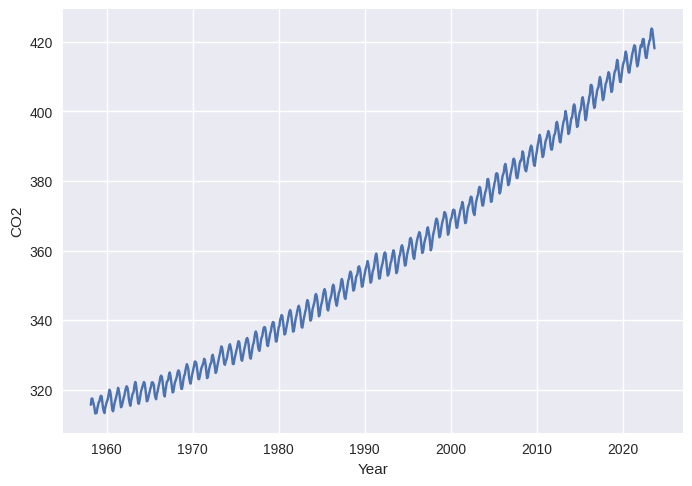

In [16]:
fig, ax = plt.subplots()
ax.plot(data["date"], data["CO2"])
ax.set_xlabel("Year")
ax.set_ylabel("CO2")

In [17]:
data = data.set_index("date", drop=True)

In [18]:
data

,Yr,Mn,CO2
date,,,
1958-03-01,1958,3,315.71
1958-04-01,1958,4,317.45
1958-05-01,1958,5,317.51
1958-07-01,1958,7,315.87
1958-08-01,1958,8,314.93
...,...,...,...
2023-05-01,2023,5,423.78
2023-06-01,2023,6,423.39
2023-07-01,2023,7,421.62


In [19]:
data = data.query("date >= 1960")

Text(0, 0.5, 'CO2')

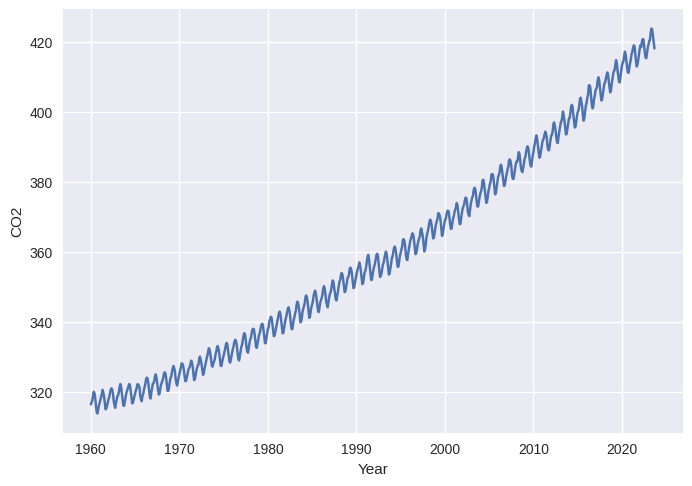

In [20]:
fig, ax = plt.subplots()
ax.plot(data.index, data["CO2"])
ax.set_xlabel("Year")
ax.set_ylabel("CO2")

Text(0, 0.5, 'CO2')

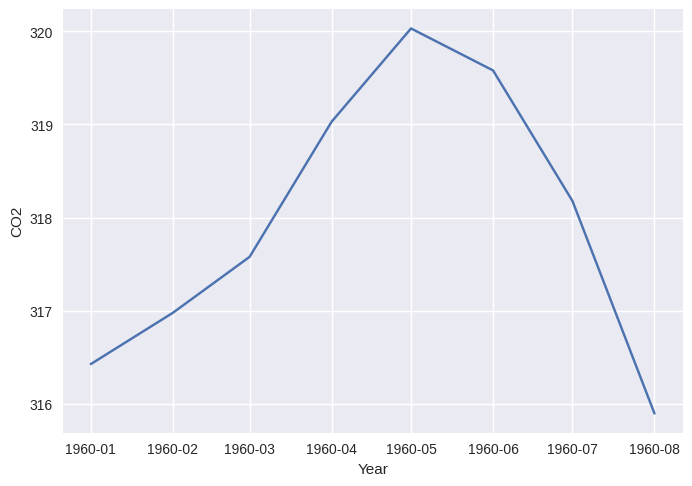

In [21]:
S = 8
fig, ax = plt.subplots()
ax.plot(data.index[:S], data["CO2"][:S])
ax.set_xlabel("Year")
ax.set_ylabel("CO2")

In [22]:
data.loc[:, "time"] = 0.

/tmp/ipykernel_24730/2352591742.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "time"] = 0.


In [23]:
data.iloc[1:, -1] = np.cumsum((data.index[1:]  - data.index[:-1]).days)

In [24]:
data

,Yr,Mn,CO2,time
date,,,,
1960-01-01,1960,1,316.43,0.0
1960-02-01,1960,2,316.98,31.0
1960-03-01,1960,3,317.58,60.0
1960-04-01,1960,4,319.03,91.0
1960-05-01,1960,5,320.03,121.0
...,...,...,...,...
2023-05-01,2023,5,423.78,23131.0
2023-06-01,2023,6,423.39,23162.0
2023-07-01,2023,7,421.62,23192.0


In [25]:
data.loc[:, "time"] = np.arange(0., len(data))

In [26]:
data

,Yr,Mn,CO2,time
date,,,,
1960-01-01,1960,1,316.43,0.0
1960-02-01,1960,2,316.98,1.0
1960-03-01,1960,3,317.58,2.0
1960-04-01,1960,4,319.03,3.0
1960-05-01,1960,5,320.03,4.0
...,...,...,...,...
2023-05-01,2023,5,423.78,757.0
2023-06-01,2023,6,423.39,758.0
2023-07-01,2023,7,421.62,759.0


In [27]:
data.loc[:, "time"] /= 1000.0

In [28]:
data

,Yr,Mn,CO2,time
date,,,,
1960-01-01,1960,1,316.43,0.000
1960-02-01,1960,2,316.98,0.001
1960-03-01,1960,3,317.58,0.002
1960-04-01,1960,4,319.03,0.003
1960-05-01,1960,5,320.03,0.004
...,...,...,...,...
2023-05-01,2023,5,423.78,0.757
2023-06-01,2023,6,423.39,0.758
2023-07-01,2023,7,421.62,0.759


In [29]:
x = data.time.values.tolist()
y = torch.tensor(data.CO2.values).float()

In [30]:
ytrain = y.cuda()

In [31]:
ytrain = (ytrain - ytrain.mean()) / ytrain.std()

In [32]:
n = len(ytrain)
ytest = ytrain[int(0.85 * n):]
ytrain =  ytrain[:int(0.85 * n)]
assert len(ytest) + len(ytrain) == n

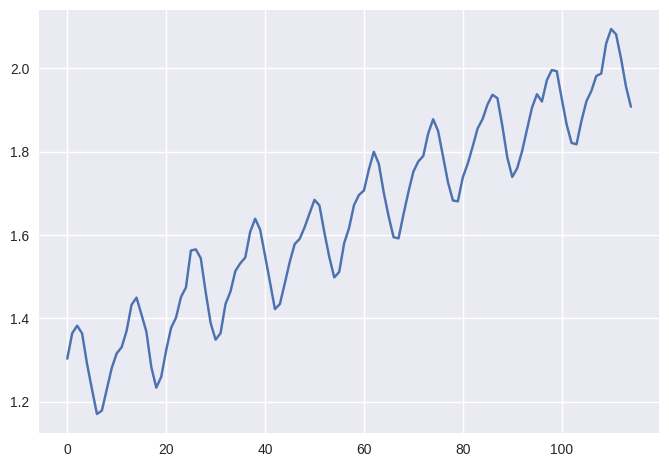

In [33]:
plt.plot(ytest.detach().cpu())

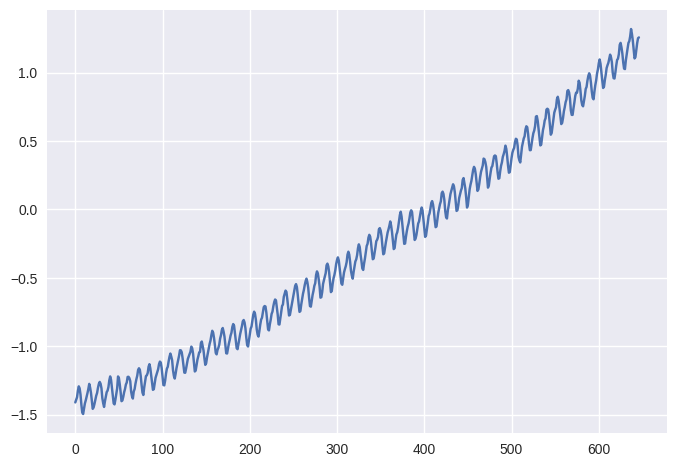

In [34]:
plt.plot(ytrain.detach().cpu())

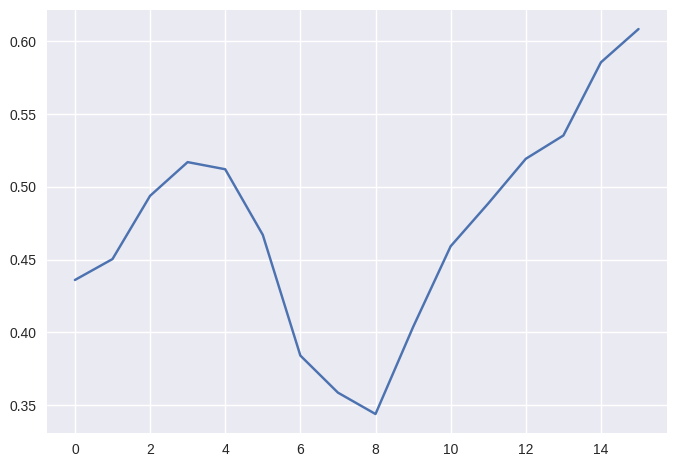

In [35]:
# plt.plot(ytrain[64:64+16].detach().cpu())
plt.plot(ytrain[502:502+16].detach().cpu())

In [36]:
len(ytrain)

647

In [37]:
batch_t = torch.arange(len(ytrain), device=torch.device("cuda"), dtype=torch.float32).unsqueeze_(1)
batch_t /= 1000.
batch_t.size()

torch.Size([647, 1])

In [38]:
batch_tt =  torch.arange(batch_t.size(0),
                         y.size(0),
                         device=torch.device("cuda"), 
                         dtype=torch.float32).unsqueeze_(1).div_(1000.)
batch_tt.size()

torch.Size([115, 1])

In [39]:
batch_y = ytrain.clone().unsqueeze(1)
batch_yy = ytest.clone().unsqueeze(1)
batch_y.size(), batch_yy.size()

(torch.Size([647, 1]), torch.Size([115, 1]))

In [40]:
class KernelPrimitive(Parameterized):
    
    def __init__(self):
        super().__init__()
        self.rbf = gp.kernels.RBF(input_dim=1)
        self.per = gp.kernels.Periodic(input_dim=1)
        self.lin = gp.kernels.Linear(input_dim=1, variance=torch.tensor(1.0))
        self.const = gp.kernels.Constant(input_dim=1)
        
    def get_kernels(self):
        yield self.rbf
        yield self.per
        yield self.lin
        yield self.const
    
    def get_num_kernels(self):
        return 4

class KernelLinear(gp.kernels.Kernel):
    
    def __init__(self, kernels):
        super().__init__(input_dim=1)
        lin_kernels = []
        for i, kern in enumerate(kernels):
            const_kern = gp.kernels.Constant(input_dim=1)
            lin_kernels.append(gp.kernels.Product(kern, const_kern))
        kernel = gp.kernels.Sum(*lin_kernels[:2])
        lin_kernels = lin_kernels[2:]
        
        for i in range(len(lin_kernels)):
            kernel = gp.kernels.Sum(kernel, lin_kernels[i])
        
        self.kernel = kernel
    
    def forward(self, X, Z=None, diag=False):
        return self.kernel(X, Z, diag)
          

class KernelMerge(Parameterized):
    
    def __init__(self, kernel, merges):
        super().__init__()
        self.merges = merges
        self._kernels = self.form_kernels(kernel)
                
    def merge(self, kernels):
        mkernels = PyroModule[torch.nn.ModuleList]([])
        for i in range(0, self.merges , 2):
            k1, k2 = kernels[i:i+2]
            mkernels.append(gp.kernels.Product(k1, k2))
        return mkernels
    
    def get_kernels(self):
        for kernel in self._kernels:
            yield kernel
    
    def form_kernels(self, kernel):
        kernels = list(kernel.get_kernels())
        new_kernels = []
        for m in range(self.merges):
            new_kernels.append(KernelLinear(kernels))
        return self.merge(new_kernels)

class Kernel(Parameterized):
    
    def __init__(self, ):
        super().__init__()
        self.primitive = KernelPrimitive()
        self.km1 = KernelMerge(self.primitive, 6)
        self.km2 = KernelMerge(self.km1, 4)
        self.km = gp.kernels.Sum(*self.km2._kernels)
        
    def forward(self, x, Z=None, diag=False):
        return self.km(x, Z, diag)
    

In [41]:
pyro.clear_param_store()
pyro.set_rng_seed(0)
kernel = Kernel()
model = gp.models.GPRegression(batch_t, batch_y.squeeze(), 
                               kernel=kernel, jitter=1e-3).cuda()

[-779.2301635742188, -779.4585571289062, -779.3902587890625, -779.2476806640625, -779.3143310546875, -779.0926513671875, -779.2321166992188, -779.240478515625, -779.1952514648438, -779.612060546875]


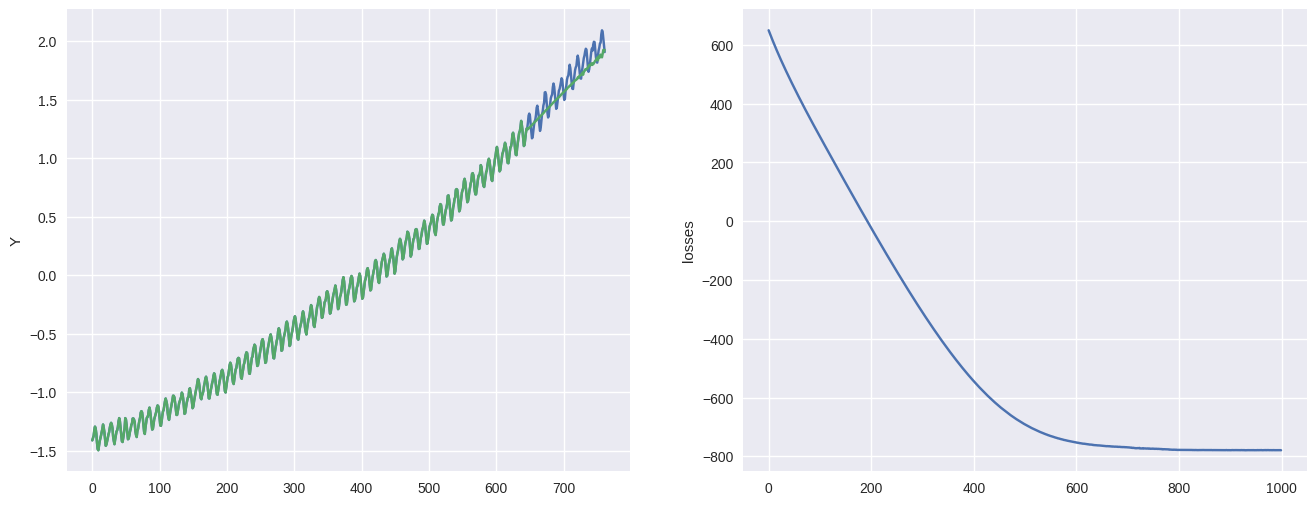

In [42]:
def train(model, batch_t, batch_y, eps):
    T = len(batch_y)
    params = model.parameters()
    optimizer = torch.optim.Adam(params, lr=1e-2)
    loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
    losses = []
    for i in range(eps):
        loss = loss_fn(model.model, model.guide)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(params, 10)
        optimizer.step()
        losses.append(loss.detach().item())
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    yloc, yscale = model(batch_tt)
    yhat = dist.Normal(yloc, yscale)()
    yhat = [i.detach().item() for i in batch_y[:, -1]] +  [i.detach().item() for i in yhat]
    y = [i.detach().item() for i in batch_y[:, -1]] + [i.detach().item() for i in batch_yy[:, -1]]
    ax1.plot(y, label="True Y")
    ax1.plot(yhat, label="Pred Y")
    ax1.set_ylabel("Y")
    ax2.plot(losses)
    ax2.set_ylabel("losses")
    
    print(losses[-10:])

train(model, batch_t, batch_y, 1000) 